# Telecom Customer Churn Analysis - Machine Learning Models Development

In [36]:
# Import all modules used in this analysis
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import warnings

In [37]:
# Suppress all warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

### Getting the data

In this section, we will:

1. Import the three datasets needed for building machine learning models.
2. Explore their features and structure.
3. Merge the datasets into a unified dataset for analysis.
4. Subset useful features for machine learning modelling.

#### 1. Import the datasets

In [38]:
# Import all datasets used in this analysis
demographics = pd.read_csv('Data/Telco_customer_churn_demographics.csv')
status = pd.read_csv('Data/Telco_customer_churn_status.csv')
services = pd.read_csv('Data/Telco_customer_churn_services.csv')

#### 2. Inspect the three datasets

In [39]:
print('Inspection of the demographics dataset:')
print(demographics.info())

Inspection of the demographics dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Customer ID           7043 non-null   object
 1   Count                 7043 non-null   int64 
 2   Gender                7043 non-null   object
 3   Age                   7043 non-null   int64 
 4   Under 30              7043 non-null   object
 5   Senior Citizen        7043 non-null   object
 6   Married               7043 non-null   object
 7   Dependents            7043 non-null   object
 8   Number of Dependents  7043 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 495.3+ KB
None


In [40]:
print('Inspection of the status dataset:')
print(status.info())

Inspection of the status dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Status ID           7043 non-null   object
 1   Customer ID         7043 non-null   object
 2   Count               7043 non-null   int64 
 3   Quarter             7043 non-null   object
 4   Satisfaction Score  7043 non-null   int64 
 5   Customer Status     7043 non-null   object
 6   Churn Label         7043 non-null   object
 7   Churn Value         7043 non-null   int64 
 8   Churn Score         7043 non-null   int64 
 9   CLTV                7043 non-null   int64 
 10  Churn Category      1869 non-null   object
 11  Churn Reason        1869 non-null   object
dtypes: int64(5), object(7)
memory usage: 660.4+ KB
None


The two columns 'Churn Category' and 'Churn Reason' have missing data, this aligns with our expectation since only churned customers have these two attributes.

In [41]:
print('Inspection of the customer services dataset:')
print(services.info())

Inspection of the customer services dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Service ID                         7043 non-null   object 
 1   Customer ID                        7043 non-null   object 
 2   Count                              7043 non-null   int64  
 3   Quarter                            7043 non-null   object 
 4   Referred a Friend                  7043 non-null   object 
 5   Number of Referrals                7043 non-null   int64  
 6   Tenure in Months                   7043 non-null   int64  
 7   Offer                              3166 non-null   object 
 8   Phone Service                      7043 non-null   object 
 9   Avg Monthly Long Distance Charges  7043 non-null   float64
 10  Multiple Lines                     7043 non-null   object 
 11  Internet Se

The 'Internet Type' column has null values. We will impute it with the string 'None' later on.

**This dataset contains the 'Churn Label' column, which is the target feature for our analysis**

#### 3. Merge the three datasets

In [42]:
data = pd.merge(status, services, on='Customer ID', how='inner')
data = pd.merge(data, demographics, on='Customer ID', how='inner')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Status ID                          7043 non-null   object 
 1   Customer ID                        7043 non-null   object 
 2   Count_x                            7043 non-null   int64  
 3   Quarter_x                          7043 non-null   object 
 4   Satisfaction Score                 7043 non-null   int64  
 5   Customer Status                    7043 non-null   object 
 6   Churn Label                        7043 non-null   object 
 7   Churn Value                        7043 non-null   int64  
 8   Churn Score                        7043 non-null   int64  
 9   CLTV                               7043 non-null   int64  
 10  Churn Category                     1869 non-null   object 
 11  Churn Reason                       1869 non-null   objec

#### 4. Subsets useful features

To assess whether a feature is useful for machine learning modeling, we apply the following criteria:

1. **Not a unique identifier** – Features like 'Customer ID' are excluded.
2. **Sufficient variability** – The feature must have at least two distinct values (e.g., the feature 'Quarter' containing only "Q3" is not useful).
3. **Acceptable missing values** – The feature should have less than 15% missing data.
4. **Manageable categorical levels** – Categorical features should have fewer than 10 unique values, as too many categories can complicate one-hot encoding.
5. **Relevance for prediction** – Features like 'Churn Reason' and 'Churn Category' are available only for churned customers, making them unsuitable for predictive modeling.
6. **Other considerations** – Additional factors may also influence feature selection.

In [43]:
# These are the features selected, with 'Churn Lable' as the target variable
data = data[['Gender', 'Age', 'Married', 'Number of Dependents', 'Number of Referrals', 
             'Tenure in Months', 'Phone Service', 'Avg Monthly Long Distance Charges',
             'Multiple Lines', 'Internet Type', 'Avg Monthly GB Download', 'Online Security',
             'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
             'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing', 
             'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 
             'Total Long Distance Charges', 'Satisfaction Score', 'Churn Label']]

In [44]:
# Inspect the dataset for machine learning modelling
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Married                            7043 non-null   object 
 3   Number of Dependents               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Phone Service                      7043 non-null   object 
 7   Avg Monthly Long Distance Charges  7043 non-null   float64
 8   Multiple Lines                     7043 non-null   object 
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   objec

### Data Cleaning

In this section, we will perform the following data cleaning steps:

1. **Convert binary features to numeric** – Identify categorical variables with exactly two distinct values and convert them into integer features (0 and 1).
2. **Apply one-hot encoding** – Transform categorical variables with three or more distinct values into numerical representations.
3. **Split the dataset** – Divide the data into training and testing sets for model evaluation.
4. **Feature scaling** – Standardize numeric features to ensure they have the same scale.


#### 1. Convert binary features to numeric

In [45]:
# Identify all binary features
binary_features = [] # To store all binary features
for feature in data.columns:
    if data[feature].nunique()==2:
        binary_features.append(feature)
print("All columns with only two distinct values: \n", binary_features)

All columns with only two distinct values: 
 ['Gender', 'Married', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Churn Label']


We would also like to extract all numeric features at this stage, which are the features that need to be normalized for macine leanring modelling.

In [46]:
# Extract numeric features (float and int) to apply StandardScaler, except for those whose values are either 0 or 1
numeric_features = data.select_dtypes(exclude='object').columns

In [47]:
# Inspect the distinct values of binary features
for feature in data.columns:
    if data[feature].nunique()==2:
        print("The unique values of the feature", feature, "are:", data[feature].drop_duplicates().tolist())


The unique values of the feature Gender are: ['Male', 'Female']
The unique values of the feature Married are: ['No', 'Yes']
The unique values of the feature Phone Service are: ['No', 'Yes']
The unique values of the feature Multiple Lines are: ['No', 'Yes']
The unique values of the feature Online Security are: ['No', 'Yes']
The unique values of the feature Online Backup are: ['No', 'Yes']
The unique values of the feature Device Protection Plan are: ['Yes', 'No']
The unique values of the feature Premium Tech Support are: ['No', 'Yes']
The unique values of the feature Streaming TV are: ['No', 'Yes']
The unique values of the feature Streaming Movies are: ['Yes', 'No']
The unique values of the feature Streaming Music are: ['No', 'Yes']
The unique values of the feature Unlimited Data are: ['No', 'Yes']
The unique values of the feature Paperless Billing are: ['Yes', 'No']
The unique values of the feature Churn Label are: ['Yes', 'No']


The 'Gender' column has to distinct values: 'Male' and 'Female', while others are 'Yes' and 'No'. We will convert the values 'Male' and 'Yes'to 1, 'Female' and 'No' to 0.

In [48]:
# For the column 'Gender', we convert 'Male' to 1 and 'Female' to 0
data['Gender'] = data['Gender'].map({'Male': '1', 'Female': '0'}).astype(int)

# Remove 'Gender' from binary_features after converting
binary_features.remove('Gender')

# For other columns, we convert 'Yes' to 1, 'No' to 0
for feature in binary_features:
    data[feature] = data[feature].map({'Yes': '1', 'No': '0'}).astype(int)

In [49]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   int32  
 1   Age                                7043 non-null   int64  
 2   Married                            7043 non-null   int32  
 3   Number of Dependents               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Phone Service                      7043 non-null   int32  
 7   Avg Monthly Long Distance Charges  7043 non-null   float64
 8   Multiple Lines                     7043 non-null   int32  
 9   Internet Type                      5517 non-null   object 
 10  Avg Monthly GB Download            7043 non-null   int64  
 11  Online Security                    7043 non-null   int32

#### 2. Apply one-hot encoding

We are left with the only categorical variables are 'Payment Method', 'Internet Type' and 'Contract', we would like to explore their distinct values.

In [50]:
data = pd.get_dummies(data)
print(data)

      Gender  Age  Married  Number of Dependents  Number of Referrals  \
0          1   78        0                     0                    0   
1          0   74        1                     1                    1   
2          1   71        0                     3                    0   
3          0   78        1                     1                    1   
4          0   80        1                     1                    1   
...      ...  ...      ...                   ...                  ...   
7038       0   30        0                     0                    0   
7039       1   38        1                     2                    1   
7040       0   30        1                     2                    4   
7041       0   32        1                     2                    1   
7042       1   44        0                     0                    0   

      Tenure in Months  Phone Service  Avg Monthly Long Distance Charges  \
0                    1              0          

#### 3. Split the dataset

In [51]:
# Define predictors X and target y
X = data.drop('Churn Label', axis=1)
y = data[['Churn Label']]

In [52]:
# Using test_size = 0.2 to split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("The shape of the training set is:", X_train.shape)
print("The shape of the testing set is:", X_test.shape)

The shape of the training set is: (5634, 34)
The shape of the testing set is: (1409, 34)


#### 4. Feature scaling

In [53]:
# We use standard scaler to normalize the numeric column
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

## Machine Learning Modelling

In this section, we will explore three learning algorithms: Logistic Regression, k-Nearest Neighbors, and Random Forest, through experimentation.

### Logistic Regression

#### Logistic Regression using all features

In [54]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [55]:
# Evaluation on training and testing data: accuracy and f1-score
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.94
f1-score score testing data: 0.90
Accuracy score training data: 0.97
f1-score score training data: 0.93


In [85]:
# Get features coefficients as a dataframe column
coefficients = np.transpose(logreg.coef_)
coefficients_df = pd.DataFrame(coefficients, columns=['Coefficients'])
coefficients_abs_df = pd.DataFrame(np.abs(coefficients), columns=['Coefficients_abs'])

# Get features as a dataframe column
features_df = pd.DataFrame(X_train.columns, columns=['Features'])

# Merge the previous 2 dataframes: feature importance
feature_importance = pd.concat([features_df, coefficients_df, coefficients_abs_df], axis=1)
print(feature_importance.sort_values(by=['Coefficients_abs'], ascending=False))


                             Features  Coefficients  Coefficients_abs
24                 Satisfaction Score     -7.006200          7.006200
10                    Online Security     -2.812338          2.812338
4                 Number of Referrals     -1.666017          1.666017
2                             Married      1.349469          1.349469
5                    Tenure in Months     -1.324691          1.324691
30                  Contract_Two Year     -0.887760          0.887760
19                     Monthly Charge      0.785705          0.785705
6                       Phone Service     -0.774236          0.774236
28            Contract_Month-to-Month      0.711831          0.711831
3                Number of Dependents     -0.703288          0.703288
20                      Total Charges      0.520281          0.520281
13               Premium Tech Support     -0.472922          0.472922
32         Payment Method_Credit Card     -0.445697          0.445697
11                  

In [56]:
accuracy_scores = []
f1_scores = []
for i in range(1, X_train.shape[1]+1):
    rfe = RFE(estimator=logreg, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

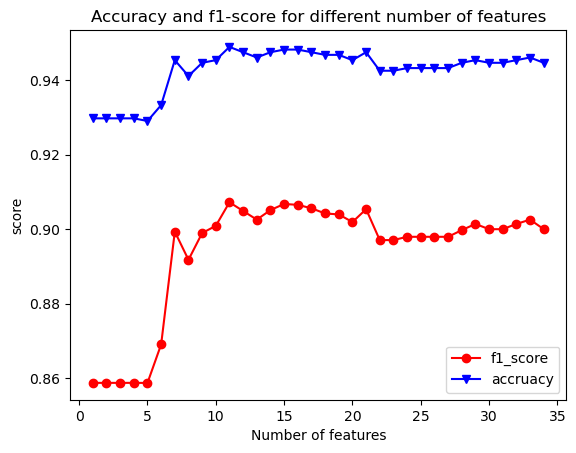

In [57]:
plt.plot(np.arange(1, X_train.shape[1] + 1), f1_scores, label = 'f1_score', color = 'r', marker = 'o')
plt.plot(np.arange(1, X_train.shape[1] + 1), accuracy_scores, label = 'accruacy', color = 'b', marker = 'v')
# plt.xticks(ticks = np.arange(0, X_train.shape[1] + 1, 1.0))
plt.title('Accuracy and f1-score for different number of features')
plt.xlabel('Number of features')
plt.ylabel('score')
plt.legend()

In [58]:
best_num_features = accuracy_scores.index(max(accuracy_scores)) + 1

In [59]:
best_logreg = RFE(estimator=logreg, n_features_to_select=best_num_features)
best_logreg.fit(X_train, y_train)

RFE(estimator=LogisticRegression(), n_features_to_select=11)

In [60]:
# Evaluation on training and testing data: accuracy and f1-score
y_pred = best_logreg.predict(X_test)
y_pred_train = best_logreg.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.95
f1-score score testing data: 0.91
Accuracy score training data: 0.96
f1-score score training data: 0.92


In [61]:
# Getting the retained features
retained_features = []
support = rfe.support_
for idx, feature in enumerate(X_train.columns):
    if support[idx]:
        retained_features.append(feature)
print(retained_features)

['Gender', 'Age', 'Married', 'Number of Dependents', 'Number of Referrals', 'Tenure in Months', 'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines', 'Avg Monthly GB Download', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Paperless Billing', 'Monthly Charge', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 'Total Long Distance Charges', 'Satisfaction Score', 'Internet Type_Cable', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year', 'Payment Method_Bank Withdrawal', 'Payment Method_Credit Card', 'Payment Method_Mailed Check']


## K-Nearest Neighbor

In [62]:
one_nn = KNeighborsClassifier(n_neighbors=1)
one_nn.fit(X_train[retained_features], y_train)

KNeighborsClassifier(n_neighbors=1)

In [63]:
#Evaluation on training and testing data: accuracy and f1-score
y_pred = one_nn.predict(X_test[retained_features])
y_pred_train = one_nn.predict(X_train[retained_features])
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.89
f1-score score testing data: 0.80
Accuracy score training data: 1.00
f1-score score training data: 1.00


In [64]:
param_grid = {
    'n_neighbors': np.arange(1,31).tolist(),
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,                # 5-fold cross-validation
    return_train_score=True  # Ensures train scores are available
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train[retained_features], y_train)

# Best hyperparameters and performance
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Best parameters: {'n_neighbors': 13}
Best cross-validation accuracy: 0.9382320910447739


In [65]:
best_knn = grid_search.best_estimator_
best_knn.fit(X_train[retained_features], y_train)

KNeighborsClassifier(n_neighbors=13)

In [66]:
#Evaluation on training and testing data: accuracy and f1-score
y_pred = best_knn.predict(X_test[retained_features])
y_pred_train = best_knn.predict(X_train[retained_features])
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.92
f1-score score testing data: 0.85
Accuracy score training data: 0.95
f1-score score training data: 0.90


## Decision Tree

In [67]:
dc_clf = DecisionTreeClassifier(random_state=42)
dc_clf.fit(X_train[retained_features], y_train)

DecisionTreeClassifier(random_state=42)

In [68]:
y_pred_train = dc_clf.predict(X_train[retained_features])
y_pred = dc_clf.predict(X_test[retained_features])
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.94
f1-score score testing data: 0.90
Accuracy score training data: 1.00
f1-score score training data: 1.00


In [69]:
param_max_depth = {'max_depth': np.arange(1, 15, 1).tolist(),
                   'criterion': ['gini', 'entropy']}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_max_depth,
    scoring='accuracy',       # Metric to optimize (e.g., 'accuracy', 'f1')
    cv=5,                   # Number of cross-validation folds             
    n_jobs=-1               # Number of parallel jobs (-1 uses all CPUs)
)
grid_search.fit(X_train[retained_features], y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

Best parameters: {'criterion': 'entropy', 'max_depth': 8}
Best cross-validation accuracy: 0.95


In [70]:
best_dt_clf = grid_search.best_estimator_
best_dt_clf.fit(X_train[retained_features], y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

In [71]:
y_pred_train = dc_clf.predict(X_train[retained_features])
y_pred = dc_clf.predict(X_test[retained_features])
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.94
f1-score score testing data: 0.90
Accuracy score training data: 1.00
f1-score score training data: 1.00
